# Coursera Capstone project
This notebook will contain the code for the IBM applied capstone project course

In [74]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from numpy.random import randint
import folium
from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from IPython.display import display
import time
import json
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [2]:
print(" Hello Capstone Project Course!")

 Hello Capstone Project Course!


## Introduction - Purpose of the project
I'll now be acquiring information regarding Milan's boroughs and will perform an analysis similar to what we've done with Toronto and NY. I'll then proceed to compare it to other cities. The goal is to get insight about how cities from very different places compare and if their neighbourhoods can be distinguished by a clustering algorithm, depending on the criteria used. The analysis will provide information on how to distinguish between parts of a city, and how different kinds of neighbourhood (residential, touristic, financial...) might compare between cities. This project is obviously limited in scope but it provides an interesting starting point for further work on the same data and topics, such as:
- analysis of restaurants/hotels ratings in different kind of neighbourhoods;
- comparison of group of clusters;
- correlation of venues with other indicators such as population age, income, etc...

## Data
Milan data are not readily available as for NY or Toronto; in order to build a suitable database of Boroughs and coordinates, I am going to select the main boroughs as listed on the wikipedia page, and I am getting their coordinates from an institutional database containing all coordinates from every single address in Milan, by averaging the coordinates which are listed in a given area. The link to the database is attached a few cells below.

Cleaning and grouping of Milan's database leads to a table of neighbourhoods with average coordinates for each one of them. Location of the coordinates on the map confirms the correctness of the operation. Information on the neighbourhood venues is then obtained through Foursquare API.

Additional data is under consideration for further analysis,for instance it would be interesting to check venues (especially restaurants, hotels et similia) ratings and see if they correlate with the kind of area.

Data from Toronto from the part of the project.


In [11]:
url = "https://en.wikipedia.org/wiki/Zones_of_Milan"
r = requests.get(url)
soup = BeautifulSoup(r.content, 'lxml') 
#print(soup.prettify())
My_table = soup.find('table',{'class':'wikitable sortable'})
#My_table
ths = My_table.find_all('th')
headings = [th.text.strip() for th in ths]
headings[0:6]

['Borough',
 'Name',
 'Area(km2)',
 'Population(2014)',
 'Population density(inhabitants/km2)',
 'Quartieri (districts)']

In [12]:
rows=[]
tools=[]
cols=[]
for link in My_table.find_all('tr'):
    tools = link.find_all('td')
    #print(tools.extend(th.find_all(text='a')))
    #zone = name.find_all('td')
    #print(type(name))
    rows.append(tools)
    #print(link.get_text('title'))
rows[4][1].get_text()
#print(tools)
#cols

'Porta Vittoria, Forlanini'

In [13]:
table_df = pd.DataFrame(columns=["Code", "Borough", "Neighbourhood"])
for rrx in range(9):
    rr=rrx+1
    table_df = table_df.append({
    "Code": rows[rr][0].get_text('title'),
    "Borough":  rows[rr][1].get_text(),
    "Neighbourhood": rows[rr][5].get_text()
      }, ignore_index=True)
    #print("Code: %s, Borough: %s, Neighbourhood: %s" % \
         #(rows[rr][0].get_text('title'),rows[rr][1].get_text(), rows[rr][5].get_text()))
        
table_df

,Code,Borough,Neighbourhood
0,1,Centro storico,"Brera, Centro Storico, Conca del Naviglio, Gua..."
1,2,"Stazione Centrale, Gorla, Turro, Greco, Cresce...","Adriano, Crescenzago, Gorla, Greco, Loreto, Ma..."
2,3,"Città Studi, Lambrate, Porta Venezia","Casoretto, Cimiano, Città Studi, Dosso, Lambra..."
3,4,"Porta Vittoria, Forlanini","Acquabella, Calvairate, Castagnedo, Cavriano, ..."
4,5,"Vigentino, Chiaravalle, Gratosoglio","Basmetto, Cantalupa, Case Nuove, Chiaravalle, ..."
5,6,"Barona, Lorenteggio","Arzaga, Barona, Boffalora, Cascina Bianca, Con..."
6,7,"Baggio, De Angeli, San Siro","Assiano, Baggio, Figino, Fopponino, Forze Arma..."
7,8,"Fiera, Gallaratese, Quarto Oggiaro","Boldinasco, Bullona, Cagnola, Campo dei Fiori,..."
8,9,"Porta Garibaldi, Niguarda","Affori, Bicocca, Bovisa, Bovisasca, Bruzzano, ..."


### NB
We cannot analyse Borough as listed because they are big and overly generic, plus they have elongated geographical shapes which would make the analysis not optimal. This is because the previous boroughs were merged for the sake of administrative efficiency. We can go back to a previous division for better accuracy.

In [14]:
areas = []
for rrx in range(9):
    rr=rrx+1
    areas = areas+rows[rr][1].get_text().split (",")
    #areas.append(rows[rr][1].get_text().split (","))
areas = [x.strip(' ') for x in areas]
areas

['Centro storico',
 'Stazione Centrale',
 'Gorla',
 'Turro',
 'Greco',
 'Crescenzago',
 'Città Studi',
 'Lambrate',
 'Porta Venezia',
 'Porta Vittoria',
 'Forlanini',
 'Vigentino',
 'Chiaravalle',
 'Gratosoglio',
 'Barona',
 'Lorenteggio',
 'Baggio',
 'De Angeli',
 'San Siro',
 'Fiera',
 'Gallaratese',
 'Quarto Oggiaro',
 'Porta Garibaldi',
 'Niguarda']

In [15]:
coordinates_df = pd.DataFrame(columns=[ "Borough","Latitude","Longitude"])
coordinates_df.Borough = areas

In [16]:
other_boroughs = ['Duomo','Brera','Sarpi','Ticinese']
for i in range(len(other_boroughs)):
    coordinates_df.loc[i+24] = other_boroughs[i]
    coordinates_df.Latitude[i+24]=np.nan
    coordinates_df.Longitude[i+24]=np.nan

In [17]:
coordinates_df

,Borough,Latitude,Longitude
0,Centro storico,NaN,NaN
1,Stazione Centrale,NaN,NaN
2,Gorla,NaN,NaN
3,Turro,NaN,NaN
4,Greco,NaN,NaN
5,Crescenzago,NaN,NaN
6,Città Studi,NaN,NaN
7,Lambrate,NaN,NaN
8,Porta Venezia,NaN,NaN
9,Porta Vittoria,NaN,NaN


### Inserting spatial coordinartes
Due to the unavailability of geocoder, I have found a database of Milan coordinates (for each and every address within the City area!) and I am extracting the coordinates based on matching address of Borough central location. The database is available at :

http://dati.comune.milano.it/dataset/5c6519f6-6d26-41c9-b53b-6106e08d1b90/resource/533b4e63-3d78-4bb5-aeb4-6c5f648f7f21/download/ds634_civici_coordinategeografiche_20190902_csv.zip

To do that I get the average coordinates when the borough name matches between the two tables, with the exception of "Centro storico", which corresponds to "MUNICIPIO" = 1 in the Milan_coordinates table.
We also need to make corrections on the borough names due to slight differences between tables namings.

In [2]:
milan_db = pd.read_excel('Milan_coordinates.xlsx')
milan_db.columns

Index(['MUNICIPIO', 'OPENSTREETMAP', 'PROGANNCSU', 'code', 'borough', 'Lat',
       'Lon'],
      dtype='object')

### Alternative borough selection from institutional database
We can extract neighbourhood information from the institutional database by cleaning the borough column, full on nan and numeric values here and there, to leave the string values only.

In [3]:
cleaned_milan_d_db=pd.DataFrame(columns=['MUNICIPIO', 'OPENSTREETMAP', 'PROGANNCSU', 'code', 'borough', 'Lat',
       'Lon'])
cleaned_milan_d_db = milan_db[milan_db['borough'].apply(lambda x: isinstance(x, str))]
#df = df[df['Facility Name'].apply(lambda x: isinstance(x, basestring)]

#counter=0
#for ind in range(len(milan_db.borough)):
#for ind,milan_db['borough'] in milan_db.iterrows():
#    if type(milan_db.borough[ind]) == str:
#        #cleaned_milan_d_db.append(milan_db[ind])
#        cleaned_milan_d_db.iloc[counter]=milan_db[ind]
#        counter+=1

In [4]:
areas = cleaned_milan_d_db.borough.unique()

We can now get average coordinates for each neighbourhood.

In [15]:
inst_coordinates_df = pd.DataFrame(columns=[ "Borough","Latitude","Longitude"])
inst_coordinates_df.Borough = areas
inst_coordinates_df.Latitude=np.nan
inst_coordinates_df.Longitude=np.nan

In [16]:
for yy in range(len(inst_coordinates_df.Borough)):
    name = inst_coordinates_df.Borough[yy]
    bor = milan_db[milan_db.borough == name]
    inst_coordinates_df.Latitude[yy]= bor.Lat.mean()
    inst_coordinates_df.Longitude[yy]= bor.Lon.mean()

c:\Conda4\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\Conda4\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [7]:
print(inst_coordinates_df.head())
print(inst_coordinates_df.shape)

                Borough   Latitude  Longitude
0                 DUOMO  45.463216   9.187042
1                 BRERA  45.473397   9.187424
2             GUASTALLA  45.463486   9.202288
3  Giardini Pta Venezia  45.474080   9.201534
4             VIGENTINA  45.451611   9.192733
(88, 3)


### END

In [19]:
centro = milan_db[milan_db.MUNICIPIO == 1]
coordinates_df.Latitude[0]= centro.Lat.mean()
coordinates_df.Longitude[0]= centro.Lon.mean()

Renaming some boroughs

In [20]:
coordinates_df.Borough[3]='Vle Monza'
coordinates_df.Borough[2]='Isola'
coordinates_df.Borough[5]='Padova'
coordinates_df.Borough[9]='Guastalla'
coordinates_df.Borough[18]='S. Siro'
coordinates_df.Borough[19]='Tre Torri'

In [21]:
for xx in range(1,28):
    name = coordinates_df.Borough[xx].upper()
    if name == 'STAZIONE CENTRALE':
        name = 'CENTRALE'
    elif name == 'PORTA VENEZIA':
        name = 'BUENOS AIRES - VENEZIA'
    elif name =='CITTÀ STUDI':
        name = 'CITTA\' STUDI'
    elif name=='FORLANINI':
        name='Parco Forlanini - ORTICA'
    elif name=='VIGENTINO':
        name='VIGENTINA'
    elif name=='GRATOSOGLIO':
        name ='GRATOSOGLIO - TICINELLO'
    elif name == 'DE ANGELI':
        name = 'DE ANGELI - MONTE ROSA'
    elif name == 'PORTA GARIBALDI':
        name = 'GARIBALDI REPUBBLICA'
    elif name == 'NIGUARDA':
        name = "NIGUARDA - CA' GRANDA"
    bor = milan_db[milan_db.borough == name]
    coordinates_df.Latitude[xx]= bor.Lat.mean()
    coordinates_df.Longitude[xx]= bor.Lon.mean()

In [22]:
coordinates_df

,Borough,Latitude,Longitude
0,Centro storico,45.3917,9.18577
1,Stazione Centrale,45.486,9.20433
2,Isola,45.4907,9.18961
3,Vle Monza,45.5116,9.22721
4,Greco,45.5033,9.20728
5,Padova,45.5021,9.23471
6,Città Studi,45.4786,9.23005
7,Lambrate,45.479,9.24471
8,Porta Venezia,45.4775,9.21479
9,Guastalla,45.4635,9.20229


### Acquisition of venue informations regarding Milan Boroughs

We are now going to use foursquare API to get information on Milan's boroughs.

### NB:
as you can see I have produced two lists of boroughs/neighbourhoods. In the next command I'm allowing to switch from one to the other for the coming analysis.

In [17]:
short_coordinates_df = coordinates_df # saving short list in separate df
coordinates_df = inst_coordinates_df

NameError: name 'coordinates_df' is not defined

In [83]:
latitude, longitude =45.4632,9.18704

# create map of Milan using latitude and longitude values
map_milan = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough in zip(coordinates_df['Latitude'], coordinates_df['Longitude'], coordinates_df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_milan)  
    
map_milan

### Foursquare credentials and version

In [84]:
CLIENT_ID = 'Q5JFHWQ0A5KGBLIHSUDYF0FLVARXYNMOTVJXPFR300E20NTW' # your Foursquare ID
CLIENT_SECRET = 'URBNDCCDV0MEZ4OPEZSHHRUUHRW4ZXQZUVLZ5OEEEDJY5NP4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius=500
LIMIT=100

Your credentails:
CLIENT_ID: Q5JFHWQ0A5KGBLIHSUDYF0FLVARXYNMOTVJXPFR300E20NTW
CLIENT_SECRET:URBNDCCDV0MEZ4OPEZSHHRUUHRW4ZXQZUVLZ5OEEEDJY5NP4


In [85]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We can now get information about Milan's venues.

In [86]:
milan_venues = getNearbyVenues(names=coordinates_df['Borough'],
                                   latitudes=coordinates_df['Latitude'],
                                   longitudes=coordinates_df['Longitude']
                                  )

DUOMO
BRERA
GUASTALLA
Giardini Pta Venezia
VIGENTINA
TICINESE
MAGENTA - S. VITTORE
GRECO
GARIBALDI REPUBBLICA
SARPI
CENTRALE
MACIACHINI - MAGGIOLINA
DERGANO
AFFORI
Parco Nord
BRUZZANO
NIGUARDA - CA' GRANDA
ISOLA
FARINI
BOVISA
PADOVA
BICOCCA
BOVISASCA
COMASINA
VLE MONZA
Parco Lambro - CIMIANO
CITTA' STUDI
BUENOS AIRES - VENEZIA
LORETO
ADRIANO
LAMBRATE
XXII MARZO
PTA ROMANA
CORSICA
UMBRIA - MOLISE
Parco Forlanini - ORTICA
ORTOMERCATO
MECENATE
Parco Monlu├¿ - PONTE LAMBRO
ROGOREDO
LODI - CORVETTO
TRIULZO SUPERIORE
SCALO ROMANA
Ex OM - MORIVIONE
Parco delle Abbazie
RIPAMONTI
QUINTOSOLE
TIBALDI
STADERA
GRATOSOGLIO - TICINELLO
CHIARAVALLE
S. CRISTOFORO
RONCHETTO S/N
TORTONA
NAVIGLI
WASHINGTON
GIAMBELLINO
BANDE NERE
LORENTEGGIO
Parco dei Navigli
CANTALUPA
BARONA
RONCHETTO DELLE RANE
MUGGIANO
TRE TORRI
QUARTO CAGNINO
QT 8
SELINUNTE
PAGANO
FORZE ARMATE
PORTELLO
DE ANGELI - MONTE ROSA
BAGGIO
Parco Bosco in citt├á
QUINTO ROMANO
S. SIRO
VILLAPIZZONE
GALLARATESE
TRENNO
FIGINO
Parco Agricolo Sud
Par

In [87]:
print(milan_venues.shape)
milan_venues.head()

(2370, 7)


,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,DUOMO,45.463216,9.187042,Piz,45.462163,9.185767,Pizza Place
1,DUOMO,45.463216,9.187042,Ciacco. Gelato senz'altro,45.463704,9.186796,Ice Cream Shop
2,DUOMO,45.463216,9.187042,Starbucks Reserve Roastery,45.464920,9.186153,Coffee Shop
3,DUOMO,45.463216,9.187042,Piazza del Duomo,45.464190,9.189527,Plaza
4,DUOMO,45.463216,9.187042,Bialetti Store,45.464775,9.188343,Kitchen Supply Store


## Analyse neighbourhoods
Using one hot encoding to organise information about venue categories.

In [88]:
# one hot encoding
milan_onehot = pd.get_dummies(milan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
milan_onehot['Borough'] = milan_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [milan_onehot.columns[-1]] + list(milan_onehot.columns[:-1])
milan_onehot = milan_onehot[fixed_columns]

milan_onehot.head()

,Borough,Abruzzo Restaurant,Accessories Store,Adult Education Center,African Restaurant,Airport,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,...,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,DUOMO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DUOMO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,DUOMO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,DUOMO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,DUOMO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
milan_grouped = milan_onehot.groupby('Borough').mean().reset_index()
milan_grouped.head()

,Borough,Abruzzo Restaurant,Accessories Store,Adult Education Center,African Restaurant,Airport,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,...,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,ADRIANO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AFFORI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BAGGIO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BANDE NERE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BARONA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Printing the top 5 venues of each neighbourhood, and making a database with the top 10 per borough.

In [90]:
num_top_venues = 5

for hood in milan_grouped['Borough']:
    print("----"+hood+"----")
    temp = milan_grouped[milan_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ADRIANO----
                venue  freq
0  Italian Restaurant  0.18
1         Supermarket  0.14
2                Café  0.09
3      Ice Cream Shop  0.05
4              Hostel  0.05


----AFFORI----
                venue  freq
0                Park  0.12
1  Italian Restaurant  0.12
2         Supermarket  0.12
3                Café  0.12
4         Pizza Place  0.12


----BAGGIO----
                 venue  freq
0   Italian Restaurant   0.2
1          Pizza Place   0.2
2            Gastropub   0.1
3    Convenience Store   0.1
4  Japanese Restaurant   0.1


----BANDE NERE----
            venue  freq
0            Café  0.15
1           Hotel  0.10
2  Ice Cream Shop  0.10
3             Pub  0.05
4      Restaurant  0.05


----BARONA----
          venue  freq
0  Soccer Field   0.2
1    Food Court   0.1
2        Bakery   0.1
3          Café   0.1
4       Theater   0.1


----BICOCCA----
                venue  freq
0                Café  0.28
1  Italian Restaurant  0.14
2    Sushi Restaurant  0

In [91]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [132]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
milan_venues_sorted = pd.DataFrame(columns=columns)
milan_venues_sorted['Borough'] = milan_grouped['Borough']

for ind in np.arange(milan_grouped.shape[0]):
    milan_venues_sorted.iloc[ind, 1:] = return_most_common_venues(milan_grouped.iloc[ind, :], num_top_venues)

milan_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ADRIANO,Italian Restaurant,Supermarket,Café,Bakery,Arts & Entertainment,Soccer Field,Bistro,Pharmacy,Furniture / Home Store,Coffee Shop
1,AFFORI,Supermarket,Café,Italian Restaurant,Park,Pizza Place,Cocktail Bar,Fried Chicken Joint,Pool Hall,Salon / Barbershop,Hotel
2,BAGGIO,Pizza Place,Italian Restaurant,Gastropub,Convenience Store,Café,Bar,Supermarket,Japanese Restaurant,French Restaurant,Fried Chicken Joint
3,BANDE NERE,Café,Ice Cream Shop,Hotel,Restaurant,Hobby Shop,Diner,Pub,Plaza,Pizza Place,Food Court
4,BARONA,Soccer Field,Bakery,Japanese Restaurant,Tennis Stadium,Athletics & Sports,Trattoria/Osteria,Theater,Café,Food Court,Food & Drink Shop


# Clustering boroughs

In [133]:
kclusters = 4

milan_grouped_clustering = milan_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(milan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:89]

array([1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 1,
       1, 0, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 0, 1, 3, 1,
       3, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 3, 3, 0, 1, 3, 1, 3, 3, 3, 3,
       1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [134]:
# add clustering labels
milan_venues_sorted.insert(0, 'Cluster Labels',kmeans.labels_.astype(int))

milan_merged = coordinates_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
milan_merged = milan_merged.join(milan_venues_sorted.set_index('Borough'), on='Borough')

milan_merged.head()

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,DUOMO,45.463216,9.187042,1.0,Italian Restaurant,Ice Cream Shop,Hotel,Café,Plaza,Pizza Place,Monument / Landmark,Bakery,Sandwich Place,Cocktail Bar
1,BRERA,45.473397,9.187424,1.0,Italian Restaurant,Ice Cream Shop,Restaurant,Hotel,Plaza,Wine Bar,Pizza Place,Japanese Restaurant,Pastry Shop,Dessert Shop
2,GUASTALLA,45.463486,9.202288,1.0,Pizza Place,Italian Restaurant,Clothing Store,Sandwich Place,Bistro,Cocktail Bar,Café,Sporting Goods Shop,Ice Cream Shop,Hotel
3,Giardini Pta Venezia,45.474080,9.201534,1.0,Italian Restaurant,Hotel,Pizza Place,Café,Gay Bar,Art Gallery,Cocktail Bar,Hookah Bar,Bistro,Burger Joint
4,VIGENTINA,45.451611,9.192733,3.0,Pizza Place,Café,Wine Bar,Burger Joint,Bistro,Park,Cocktail Bar,Restaurant,Mexican Restaurant,Bed & Breakfast


In [135]:
milan_merged = milan_merged.dropna()

In [259]:
milan_merged.to_excel('Milan_clustered_table.xls')

# Clusters map

In [136]:
# create map
map_milan_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(milan_merged['Latitude'], milan_merged['Longitude'], milan_merged['Borough'], milan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_milan_clusters)
       
map_milan_clusters

## Examining clusters
by checking clusters composition we can understand something about how they were made.

### Analysis of neighbourhoods from institutional db, 4 clusters
A clear pattern emerges from the clustering. Note that using a different number of clusters doen not change general result as the main groups remain. Increasing the number of clusters generates very small, even unitary clusters which could be genuinely different from the others and might be valuable for other kinds of analysis.

- 0: mostly suburban or semi-rural location.
    Characterised by the presence of sport infrastructure.
- 1: contains all central and urban locations, plus others close to important transport links such as motorways and railways.
    Featuring primarly restaurants, cafes, pizza places and similar public venues.
- 2: outer locations, close to the outer ring motorway.
    Mainly hotels and restauration. 
- 3: this cluster represents a very clear belt around town, mostly just outside the city inner ring road (Circonvallazione).
    Prevalence of pizza places, shops and services.
    
The most interesting point is the comparison between clusters 1 and 3, where we can see a slight different focus towards services, shops and fast food when getting out of the center towards more working class areas.

In [137]:
for clst in range(kclusters):
    
    display(milan_merged.loc[milan_merged['Cluster Labels'] == clst, milan_merged.columns[[1] + list(range(4, milan_merged.shape[1]))]])

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,45.520614,Soccer Field,Football Stadium,Hotel,Food Truck,Flower Shop,Food,Food & Drink Shop,Food Court,Yoga Studio,Fast Food Restaurant
63,45.451647,Juice Bar,Soccer Field,Airport,Neighborhood,Football Stadium,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant
69,45.461119,Farm,Pizza Place,Supermarket,Soccer Field,Yoga Studio,Food Court,Flower Shop,Food,Food & Drink Shop,Food Truck
73,45.479571,Recreation Center,Brazilian Restaurant,Soccer Field,Hotel,Playground,Food Court,Flower Shop,Food,Food & Drink Shop,Food Truck
74,45.477738,Recreation Center,Soccer Field,Supermarket,Playground,Food Court,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck


,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,45.463216,Italian Restaurant,Ice Cream Shop,Hotel,Café,Plaza,Pizza Place,Monument / Landmark,Bakery,Sandwich Place,Cocktail Bar
1,45.473397,Italian Restaurant,Ice Cream Shop,Restaurant,Hotel,Plaza,Wine Bar,Pizza Place,Japanese Restaurant,Pastry Shop,Dessert Shop
2,45.463486,Pizza Place,Italian Restaurant,Clothing Store,Sandwich Place,Bistro,Cocktail Bar,Café,Sporting Goods Shop,Ice Cream Shop,Hotel
3,45.474080,Italian Restaurant,Hotel,Pizza Place,Café,Gay Bar,Art Gallery,Cocktail Bar,Hookah Bar,Bistro,Burger Joint
5,45.451560,Cocktail Bar,Italian Restaurant,Ice Cream Shop,Hotel,Wine Bar,Café,Seafood Restaurant,Sushi Restaurant,Sandwich Place,Clothing Store
6,45.463442,Italian Restaurant,Café,Pizza Place,Science Museum,American Restaurant,Plaza,Sandwich Place,Gym,Hotel,Bookstore
8,45.483457,Italian Restaurant,Restaurant,Pizza Place,Cocktail Bar,Furniture / Home Store,Sushi Restaurant,Café,Plaza,Coffee Shop,Ice Cream Shop
9,45.482910,Italian Restaurant,Restaurant,Pizza Place,Chinese Restaurant,Seafood Restaurant,Hotel,Burger Joint,Wine Bar,Ice Cream Shop,Bistro
10,45.485976,Hotel,Café,Italian Restaurant,Pizza Place,Restaurant,Ice Cream Shop,Sandwich Place,Bistro,Chinese Restaurant,Supermarket
15,45.527021,Bakery,Italian Restaurant,Gift Shop,Ice Cream Shop,Gym / Fitness Center,Train Station,Pizza Place,Diner,Dive Bar,Flea Market


,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
60,45.419081,Café,Restaurant,Hotel,Mediterranean Restaurant,Yoga Studio,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck
80,45.453983,Restaurant,Mediterranean Restaurant,Football Stadium,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fast Food Restaurant
85,45.512879,Hotel,Café,Restaurant,Spa,Food Court,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck


,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,45.451611,Pizza Place,Café,Wine Bar,Burger Joint,Bistro,Park,Cocktail Bar,Restaurant,Mexican Restaurant,Bed & Breakfast
7,45.503287,Pizza Place,Italian Restaurant,Other Repair Shop,Plaza,Chinese Restaurant,Cocktail Bar,Tunnel,Supermarket,Hotel,Steakhouse
11,45.496908,Pizza Place,Italian Restaurant,Seafood Restaurant,Park,Middle Eastern Restaurant,Gym / Fitness Center,Sushi Restaurant,Supermarket,Noodle House,Café
12,45.502022,Restaurant,Pizza Place,Food Court,Bistro,Peruvian Restaurant,Gym / Fitness Center,Food,Performing Arts Venue,Plaza,Pet Store
13,45.514835,Supermarket,Café,Italian Restaurant,Park,Pizza Place,Cocktail Bar,Fried Chicken Joint,Pool Hall,Salon / Barbershop,Hotel
16,45.516780,Pizza Place,Café,Hotel,Sushi Restaurant,Yoga Studio,Food Court,Flower Shop,Food,Food & Drink Shop,Food Truck
20,45.502144,Pizza Place,Restaurant,Event Space,Gay Bar,Park,Supermarket,Performing Arts Venue,Café,Food & Drink Shop,Chinese Restaurant
23,45.526144,Bus Station,Fast Food Restaurant,Supermarket,Bakery,General Entertainment,Pizza Place,Metro Station,Hostel,Bar,Fountain
26,45.478581,Café,Pizza Place,Pub,Pool,Metro Station,Park,Gym,Bar,Plaza,Supermarket
30,45.479002,Italian Restaurant,Supermarket,Plaza,Steakhouse,Hotel,Basketball Court,Theater,Buffet,Park,Pizza Place


# Comparison between cities
I'll now proceed to compare Milan to other towns. Interesting comparisons would be with other European economic capitals of similar size (Munich, Barcelona, Vienna...) or Toronto itself.
Possible ideas:
- compare different towns to see if they are distinguishable in terms of neighbourhood composition
- see where given kinds of restaurant or other activity are more popular 

For instance I could import the grouped table from the Toronto exercise, join it to the one from Milan and see if, when clustered, the neughbourhoods/boroughs get mixed up or are kept separated.

In [251]:
trno_grouped = pd.read_excel('toronto_grouped_table.xls')

In [252]:
trno_grouped_lab = trno_grouped.assign(lab = "Trno")

In [253]:
milan_grouped.to_excel('milan_gouped_table.xlsx') # saving data in an excel file

In [254]:
milan_grouped_lab=milan_grouped.assign(lab = "Mil")

## Mixing Toronto and Milan neighbourhoods, would we be able to distinguish them?

In [275]:
mil_trno_joined = pd.concat([trno_grouped_lab,milan_grouped_lab],axis = 0)
mil_trno_joined=mil_trno_joined.reset_index(drop=True)

In [276]:
mil_trno_joined = mil_trno_joined.fillna(0)
mil_trno_joined.head()

,Abruzzo Restaurant,Accessories Store,Adult Education Center,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,lab
0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0000,Trno
1,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0000,Trno
2,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0000,Trno
3,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0625,Trno
4,0.0,0.0,0.0,0.0,0.0,0.0625,0.0625,0.0625,0.125,0.1875,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0000,Trno


In [277]:
mil_trno_joined.shape

(126, 347)

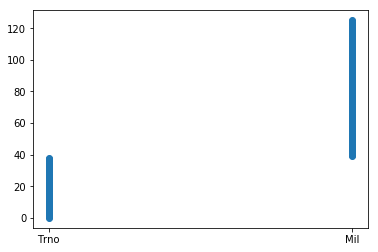

In [278]:
plt.scatter(mil_trno_joined.lab,mil_trno_joined.index)

### Analysis with 2 clusters

In [279]:
kclusters = 2

mil_trno_joined_clustering = mil_trno_joined.drop(['Borough','lab'], 1)

# run k-means clustering
kmeans_joined = KMeans(n_clusters=kclusters, random_state=5).fit(mil_trno_joined_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans_joined.labels_[0:10])
print(kmeans_joined.labels_[60:70])

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


([<matplotlib.axis.YTick at 0x19f119ca198>,
 <a list of 2 Text yticklabel objects>)

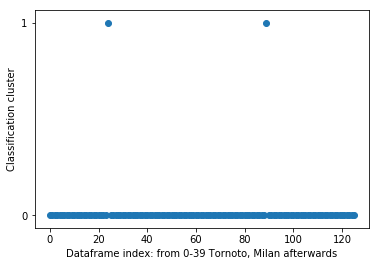

In [280]:
plt.scatter(mil_trno_joined.index,kmeans_joined.labels_)
plt.ylabel("Classification cluster")
plt.xlabel("Dataframe index: from 0-39 Tornoto, Milan afterwards")
plt.yticks(np.unique(kmeans_joined.labels_))

The answer is no, we wouldn't! when clustering in 2 groups, the clusters are virtually undistinguishable, whatever value of random state we use.

### Higher number of clusters

In [281]:
kclusters = 3

mil_trno_joined_clustering = mil_trno_joined.drop(['Borough','lab'], 1)

# run k-means clustering
kmeans_joined = KMeans(n_clusters=kclusters, random_state=1,n_init=15, max_iter=400).fit(mil_trno_joined_clustering)

In [282]:
mil_trno_joined.lab[3]

'Trno'

([<matplotlib.axis.YTick at 0x19f11a5c748>,
 <a list of 3 Text yticklabel objects>)

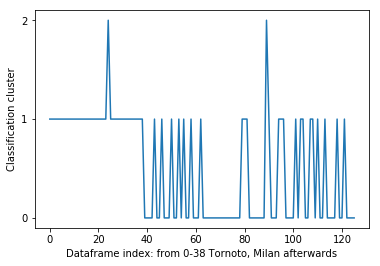

In [287]:
plt.plot(kmeans_joined.labels_)
plt.ylabel("Classification cluster")
plt.xlabel("Dataframe index: from 0-38 Tornoto, Milan afterwards")
plt.yticks(np.unique(kmeans_joined.labels_))

Results vary when changing parameters but it is possible to find that fairly often Toronto neighbourhoods cluster together quite effectively, whereas Milan's tend to mix with Toronto's in some part. We should look into this, to see if Milan's neighbourhoods clustered with toronto's are somehow different.

In [284]:
mil_trno_joined[kmeans_joined.labels_==2].Borough

24    Moore Park,Summerhill East
89            Parco Agricolo Sud
Name: Borough, dtype: object

In the analysis of Toronto neighbourhoods Moore Park,Summerhill East was clustered alone.

In [285]:
trno_merged = pd.read_excel('toronto_clustered_table.xls')
trno_milan_merged = pd.concat([trno_merged,milan_merged])
trno_milan_merged.head()

,10th Most Common Venue,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,Borough,Cluster Labels,Code,Latitude,Longitude,Neighbourhood,Unnamed: 0
0,Eastern European Restaurant,Pub,Health Food Store,Trail,Wings Joint,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,East Toronto,0.0,M4E,43.676357,-79.293031,The Beaches,37.0
1,Brewery,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Bookstore,Indian Restaurant,Sports Bar,Spa,East Toronto,0.0,M4K,43.679557,-79.352188,"The Danforth West,Riverdale",41.0
2,Liquor Store,Park,Sandwich Place,Ice Cream Shop,Pizza Place,Movie Theater,Pub,Burrito Place,Burger Joint,Brewery,East Toronto,0.0,M4L,43.668999,-79.315572,"The Beaches West,India Bazaar",42.0
3,Diner,Café,Coffee Shop,American Restaurant,Italian Restaurant,Bakery,Latin American Restaurant,Coworking Space,Bookstore,Cheese Shop,East Toronto,0.0,M4M,43.659526,-79.340923,Studio District,43.0
4,Eastern European Restaurant,Park,Bus Line,Swim School,Wings Joint,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Central Toronto,4.0,M4N,43.728020,-79.388790,Lawrence Park,44.0


In [286]:
print(trno_merged.loc[8])
print(milan_merged.loc[80])

Unnamed: 0                                         48
Code                                              M4T
Borough                               Central Toronto
Neighbourhood              Moore Park,Summerhill East
Latitude                                      43.6896
Longitude                                    -79.3832
Cluster Labels                                      1
1st Most Common Venue                      Restaurant
2nd Most Common Venue                     Wings Joint
3rd Most Common Venue                    Dessert Shop
4th Most Common Venue              Falafel Restaurant
5th Most Common Venue                     Event Space
6th Most Common Venue            Ethiopian Restaurant
7th Most Common Venue               Electronics Store
8th Most Common Venue     Eastern European Restaurant
9th Most Common Venue             Dumpling Restaurant
10th Most Common Venue                     Donut Shop
Name: 8, dtype: object
Borough                         Parco Agricolo Sud
Latitude

The similarity between the neighbourhoods might be due to a prevalence of restaurants as most popular venues in them.

It would be interesting now to see on a map if the neighbourhood of Milan clustered with Toronto's have some common property.

In [288]:
milan_merged_cc= milan_merged # comparative clustering df
milan_merged_cc['Cluster Labels'] = kmeans_joined.labels_[39:]

In [289]:
# create map
map_milan_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(milan_merged_cc['Latitude'], milan_merged_cc['Longitude'], milan_merged_cc['Borough'], milan_merged_cc['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_milan_clusters)
       
map_milan_clusters

### Conclusions
I guess we can say that there seem to be a pattern. Cluster 1, ie Toronto-like cluster, is shaped as a C around the centre of Milan. This tells us that the centre of Milan is different from Toronto's, more than the residential areas are. The analysis could be taken further, for instance by cleaning the venues cateogries further, to avoid redundancies (eg "pizza place", "pizzeria", "pizza restaurant" not grouped togheter) or by looking for what characterises clusters more in detail, and to see if it could be possible to compare clusters of similar kind (residential, services) between the cities, maybe by changing the foursquare API settings slightly.


# Analysis of restaurants (and similar lind of venues) rating, and comparative analysis

due to limitations in number of queries per day to the foursquare API, we need to put a limit on the requests, e.g. 10.

In [140]:
CLIENT_ID = 'Q5JFHWQ0A5KGBLIHSUDYF0FLVARXYNMOTVJXPFR300E20NTW' # your Foursquare ID
CLIENT_SECRET = 'URBNDCCDV0MEZ4OPEZSHHRUUHRW4ZXQZUVLZ5OEEEDJY5NP4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius=400
LIMIT=5

Your credentails:
CLIENT_ID: Q5JFHWQ0A5KGBLIHSUDYF0FLVARXYNMOTVJXPFR300E20NTW
CLIENT_SECRET:URBNDCCDV0MEZ4OPEZSHHRUUHRW4ZXQZUVLZ5OEEEDJY5NP4


In [146]:
def getNearbyVenues(names, latitudes, longitudes,section, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&section={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            section,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    #nearby_venues.columns = ['Borough', 
    #              'Neighborhood Latitude', 
    #              'Neighborhood Longitude', 
    #              'Venue',
    #               'Venue id',
     #             'Venue Latitude', 
      #            'Venue Longitude', 
       #           'Venue Category']
    
    return(nearby_venues)

In [147]:
names=coordinates_df['Borough']
latitudes=coordinates_df['Latitude']
longitudes=coordinates_df['Longitude']
section = "food"

In [148]:
milan_venues_b =getNearbyVenues(names, latitudes, longitudes,section)

DUOMO
BRERA
GUASTALLA
Giardini Pta Venezia
VIGENTINA
TICINESE
MAGENTA - S. VITTORE
GRECO
GARIBALDI REPUBBLICA
SARPI
CENTRALE
MACIACHINI - MAGGIOLINA
DERGANO
AFFORI
Parco Nord
BRUZZANO
NIGUARDA - CA' GRANDA
ISOLA
FARINI
BOVISA
PADOVA
BICOCCA
BOVISASCA
COMASINA
VLE MONZA
Parco Lambro - CIMIANO
CITTA' STUDI
BUENOS AIRES - VENEZIA
LORETO
ADRIANO
LAMBRATE
XXII MARZO
PTA ROMANA
CORSICA
UMBRIA - MOLISE
Parco Forlanini - ORTICA
ORTOMERCATO
MECENATE
Parco Monlu├¿ - PONTE LAMBRO
ROGOREDO
LODI - CORVETTO
TRIULZO SUPERIORE
SCALO ROMANA
Ex OM - MORIVIONE
Parco delle Abbazie
RIPAMONTI
QUINTOSOLE
TIBALDI
STADERA
GRATOSOGLIO - TICINELLO
CHIARAVALLE
S. CRISTOFORO
RONCHETTO S/N
TORTONA
NAVIGLI
WASHINGTON
GIAMBELLINO
BANDE NERE
LORENTEGGIO
Parco dei Navigli
CANTALUPA
BARONA
RONCHETTO DELLE RANE
MUGGIANO
TRE TORRI
QUARTO CAGNINO
QT 8
SELINUNTE
PAGANO
FORZE ARMATE
PORTELLO
DE ANGELI - MONTE ROSA
BAGGIO
Parco Bosco in citt├á
QUINTO ROMANO
S. SIRO
VILLAPIZZONE
GALLARATESE
TRENNO
FIGINO
Parco Agricolo Sud
Par

In [149]:
milan_bu = milan_venues_b
milan_venues_b.head()

,0,1,2,3,4,5,6,7
0,DUOMO,45.463216,9.187042,Piz,5728faba498e6c7b0bbeef04,45.462163,9.185767,Pizza Place
1,DUOMO,45.463216,9.187042,Hana,552ead66498ef6abfdea1c02,45.462380,9.188521,Korean Restaurant
2,DUOMO,45.463216,9.187042,Spontini,55674ae3498e86ab9947f6a5,45.463171,9.188574,Pizza Place
3,DUOMO,45.463216,9.187042,Caffè Napoli,576828cc498ec1d7fb395d70,45.462816,9.189023,Café
4,DUOMO,45.463216,9.187042,Princi,4be181c240d676b02de504ee,45.463029,9.187968,Bakery


In [150]:
milan_venues_b.columns = ['Borough','Neighborhood Latitude', 'Neighborhood Longitude','Venue','Venue id','Venue Latitude','Venue Longitude','Venue Category']

In [151]:
milan_venues_b=milan_venues_b.assign(priceTier=np.nan)
#milan_venues_b.priceTier[len(milan_venues_b.Venue)]=np.nan
#milan_venues_b.rating[len(milan_venues_b.Venue)]=np.nan
#milan_venues_b.likes[len(milan_venues_b.Venue)]=np.nan

In [152]:
milan_venues_b=milan_venues_b.assign(rating=np.nan)

In [153]:
milan_venues_b=milan_venues_b.assign(likes=np.nan)

In [2]:
milan_venues_b.head()

NameError: name 'milan_venues_b' is not defined

### Load previously saved table(necessary due to limit in foursquare API calls per day)
Due to the stringent limits on the available calls through Foursquare API, we need to save data as we get it and re-load it in the next instance when we want to collect more.

In [3]:
milan_venues_saved=pd.read_excel("milan_pop_venues.xls")

milan_venues_b=milan_venues_saved

### end

In [155]:
# get ratings
for vv in range(len(milan_venues_b.Venue)):
    venue_id=milan_venues_b["Venue id"][vv]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    rs=requests.get(url).json()
    try:
        milan_venues_b.priceTier[vv] = rs['response']['venue']['price']['tier']
    except KeyError:
        milan_venues_b.priceTier[vv]=np.nan
    #milan_venues_b.priceTier[vv] = rs['response']['venue']['attributes']['groups'][0]['items'][0]['priceTier']
    try:
        milan_venues_b.rating[vv]=rs['response']['venue']['rating']
    except KeyError:
        milan_venues_b.rating[vv]=np.nan
    try:
        milan_venues_b.likes[vv]=rs['response']['venue']['likes']['count']
    except KeyError:
        milan_venues_b.likes[vv]=np.nan
    time.sleep(0.5)
    

c:\Conda4\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\Conda4\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
c:\Conda4\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\Conda4\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [171]:
# get ratings
for vv in range(50,397):
    venue_id=milan_venues_b["Venue id"][vv]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    rs=requests.get(url).json()
    try:
        milan_venues_b.priceTier[vv] = rs['response']['venue']['price']['tier']
    except KeyError:
        milan_venues_b.priceTier[vv]=np.nan
    #milan_venues_b.priceTier[vv] = rs['response']['venue']['attributes']['groups'][0]['items'][0]['priceTier']
    try:
        milan_venues_b.rating[vv]=rs['response']['venue']['rating']
    except KeyError:
        milan_venues_b.rating[vv]=np.nan
    try:
        milan_venues_b.likes[vv]=rs['response']['venue']['likes']['count']
    except KeyError:
        milan_venues_b.likes[vv]=np.nan
    time.sleep(0.5)

c:\Conda4\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
c:\Conda4\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\Conda4\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Test extraction of information from json text---

In [172]:
milan_venues_b["Venue id"][50]

'56094102498ecb2048e05ac9'

In [173]:
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format('56094102498ecb2048e05ac9', CLIENT_ID, CLIENT_SECRET, VERSION)
rs=requests.get(url).json()

In [170]:
rs

{'meta': {'code': 429,
  'errorDetail': 'Quota exceeded',
  'errorType': 'quota_exceeded',
  'requestId': '5d9dadaddb1d810039aa0ea0'},
 'response': {}}

In [103]:
type(rs)

dict

In [107]:
try:
    print(rs['response']['venue']['rating'])
except KeyError:
    print('Niente')

Niente


### ---end

## Averaging priceTier, rating and likes per Borough

In [4]:
milan_venues_b.head()

,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category,priceTier,rating,likes
0,DUOMO,45.463216,9.187042,Piz,5728faba498e6c7b0bbeef04,45.462163,9.185767,Pizza Place,2.0,9.3,423.0
1,DUOMO,45.463216,9.187042,Hana,552ead66498ef6abfdea1c02,45.462380,9.188521,Korean Restaurant,3.0,8.6,39.0
2,DUOMO,45.463216,9.187042,Spontini,55674ae3498e86ab9947f6a5,45.463171,9.188574,Pizza Place,2.0,8.4,150.0
3,DUOMO,45.463216,9.187042,Caffè Napoli,576828cc498ec1d7fb395d70,45.462816,9.189023,Café,1.0,8.3,11.0
4,DUOMO,45.463216,9.187042,Princi,4be181c240d676b02de504ee,45.463029,9.187968,Bakery,2.0,8.2,331.0


In [5]:
milan_ratings_grouped=milan_venues_b.groupby('Borough').mean().reset_index()
milan_ratings_grouped

,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,priceTier,rating,likes
0,ADRIANO,45.511551,9.244950,45.509969,9.244983,NaN,NaN,NaN
1,AFFORI,45.514835,9.172873,45.514137,9.172773,NaN,NaN,NaN
2,BAGGIO,45.461161,9.088360,45.461568,9.091514,NaN,NaN,NaN
3,BANDE NERE,45.460724,9.138703,45.462487,9.137658,NaN,NaN,NaN
4,BARONA,45.432509,9.154128,45.434329,9.152955,NaN,NaN,NaN
5,BICOCCA,45.517169,9.210584,45.515879,9.210385,NaN,NaN,NaN
6,BOVISA,45.501875,9.165449,45.502029,9.165755,NaN,NaN,NaN
7,BOVISASCA,45.516940,9.154234,45.517535,9.152284,NaN,NaN,NaN
8,BRERA,45.473397,9.187424,45.472930,9.186405,2.80,8.42,128.6
9,BRUZZANO,45.527021,9.173297,45.526579,9.174473,NaN,NaN,NaN


We can now check how the neighbourhoods cluster based on ratings of most popular venues.

In [166]:
milan_ratings_grouped.to_excel("milan_ratings.xls")

In [167]:
milan_venues_b.to_excel("milan_pop_venues.xls")

# Alternative data-foraging: Yelp API

In [11]:
Client_ID = "sBaMvmMj9Yia30b4c8xyFQ"
API_Key = "NkxU9YvFD3jIgxA_qFx3EdjZBzKOLMvZptVBExNMJrprGtllvtL_P53SxCAm_WDKJNCl30sf-pz5PDaLGz3Ux2KWrlrK9Jk5yh4qY_CkfrqBQKln6_zjyXXN78idXXYx"

In [ ]:
# inst_coordinates_df contains neighbourhood names and coordinates

In [10]:
def getNearbyVenuesYelp(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = "https://api.yelp.com/v3/businesses/search"
        params = {'term':'food','latitude':lat, 'longitude':lng, 'radius' : 500,'sort_by':'best_match','limit':30,}
        headers = {'Authorization': 'Bearer %s' % API_Key}
        # make the GET request
        req=requests.get(url, params=params, headers=headers)
        parsed=json.loads(req.text)
        businesses=parsed['businesses']
        
        # return only relevant information for each nearby venue
        for biz in businesses:
            try:
                biz_name=biz["name"]
            except KeyError:
                biz_name =" "
            try:
                biz_id=biz["id"]
            except KeyError:
                biz_id = ' '
            try:
                biz_price=biz["price"]
            except KeyError:
                biz_price=np.nan
            try:
                biz_rating=biz["rating"]
            except KeyError:
                biz_rating=np.nan
                
            venues_list.append([(
                name, 
                lat, 
                lng, 
                biz_name,
                biz_id,
                biz_price, 
                biz_rating)])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    #nearby_venues.columns = ['Borough', 
    #              'Neighborhood Latitude', 
    #              'Neighborhood Longitude', 
    #              'Venue',
    #               'Venue id',
     #             'Venue Latitude', 
      #            'Venue Longitude', 
       #           'Venue Category']
    
    return(nearby_venues)

In [18]:
names=inst_coordinates_df['Borough']
latitudes=inst_coordinates_df['Latitude']
longitudes=inst_coordinates_df['Longitude']
milan_venues_b_yelp =getNearbyVenuesYelp(names, latitudes, longitudes)

DUOMO
BRERA
GUASTALLA
Giardini Pta Venezia
VIGENTINA
TICINESE
MAGENTA - S. VITTORE
GRECO
GARIBALDI REPUBBLICA
SARPI
CENTRALE
MACIACHINI - MAGGIOLINA
DERGANO
AFFORI
Parco Nord
BRUZZANO
NIGUARDA - CA' GRANDA
ISOLA
FARINI
BOVISA
PADOVA
BICOCCA
BOVISASCA
COMASINA
VLE MONZA
Parco Lambro - CIMIANO
CITTA' STUDI
BUENOS AIRES - VENEZIA
LORETO
ADRIANO
LAMBRATE
XXII MARZO
PTA ROMANA
CORSICA
UMBRIA - MOLISE
Parco Forlanini - ORTICA
ORTOMERCATO
MECENATE
Parco Monlu├¿ - PONTE LAMBRO
ROGOREDO
LODI - CORVETTO
TRIULZO SUPERIORE
SCALO ROMANA
Ex OM - MORIVIONE
Parco delle Abbazie
RIPAMONTI
QUINTOSOLE
TIBALDI
STADERA
GRATOSOGLIO - TICINELLO
CHIARAVALLE
S. CRISTOFORO
RONCHETTO S/N
TORTONA
NAVIGLI
WASHINGTON
GIAMBELLINO
BANDE NERE
LORENTEGGIO
Parco dei Navigli
CANTALUPA
BARONA
RONCHETTO DELLE RANE
MUGGIANO
TRE TORRI
QUARTO CAGNINO
QT 8
SELINUNTE
PAGANO
FORZE ARMATE
PORTELLO
DE ANGELI - MONTE ROSA
BAGGIO
Parco Bosco in citt├á
QUINTO ROMANO
S. SIRO
VILLAPIZZONE
GALLARATESE
TRENNO
FIGINO
Parco Agricolo Sud
Par

In [19]:
milan_venues_b_yelp.head()

,0,1,2,3,4,5,6
0,DUOMO,45.463216,9.187042,Risoelatte,GyilsXEoEw6V9tmV70ZvoA,€€,4.5
1,DUOMO,45.463216,9.187042,Luini,acm_-PPIeqdo7ZLRn5fXJw,€,4.0
2,DUOMO,45.463216,9.187042,Princi,YAvqWdS39-Lb2KyhmhYSmg,€,4.0
3,DUOMO,45.463216,9.187042,Piz,DxgcES-gFf3jFQ9OxYRI4A,€€,4.5
4,DUOMO,45.463216,9.187042,Trattoria Milanese,mmsfdsAJdKkZEr3ibI6SEA,€€€,4.5


In [20]:
milan_venues_b_yelp.columns = ['Borough','Neighborhood Latitude', 'Neighborhood Longitude','Venue','Venue id','Price','Rating']

In [21]:
milan_venues_b_yelp.to_excel("milan_ratings_yelp_rev_50_count_b.xls")

### testing yelp api

In [94]:
url = "https://api.yelp.com/v3/businesses/search"
params = {'term':'food','latitude':45.463171, 'longitude':9.188574, 'radius' : 500,'limit':5,}
headers = {'Authorization': 'Bearer %s' % API_Key}
        # make the GET request
req=requests.get(url, params=params, headers=headers)
parsed=json.loads(req.text)

In [95]:
bizz =parsed['businesses']
for biz in bizz:
    print("Name:", biz["name"])
    print("Rating:", biz["rating"])
    print("Address:", " ".join(biz["location"]["display_address"]))
    print("Phone:", biz["phone"])
    print("\n")

Name: Luini
Rating: 4.0
Address: Via Santa Radegonda 16 20121 Milan Italy
Phone: +390286461917


Name: Princi
Rating: 4.0
Address: Via Speronari 6 20123 Milan Italy
Phone: +3902874797


Name: Piz
Rating: 4.5
Address: Via Torino 34 20123 Milan Italy
Phone: +390286453482


Name: Papà Francesco
Rating: 4.0
Address: Via Marino Tommaso 5 20121 Milan Italy
Phone: +3902862177


Name: Camparino in Galleria
Rating: 4.5
Address: Galleria Vittorio Emanuele 20122 Milan Italy
Phone: +390286464435




### end

In [38]:
milan_venues_b_yelp=pd.read_excel("milan_ratings_yelp_rev_50_count_b.xls")

In [39]:
price_en={"Price":{"€":1.0,"€€":2.0,"€€€":3.0,"€€€€":4.0,"€€€€€":5.0}}
milan_venues_b_yelp.replace(price_en,inplace=True)

In [73]:
milan_venues_b_yelp=milan_venues_b_yelp.astype({"Price":"float"})

ValueError: could not convert string to float: '€€€€'

In [40]:
milan_grouped_yelp=milan_venues_b_yelp.groupby('Borough').mean().reset_index()

In [43]:
milan_grouped_yelp

,Borough,Neighborhood Latitude,Neighborhood Longitude,Price,Rating
0,ADRIANO,45.511551,9.244950,2.000000,3.850000
1,AFFORI,45.514835,9.172873,1.700000,3.866667
2,BAGGIO,45.461161,9.088360,2.600000,3.888889
3,BANDE NERE,45.460724,9.138703,2.000000,3.166667
4,BARONA,45.432509,9.154128,2.000000,3.500000
5,BICOCCA,45.517169,9.210584,1.875000,3.666667
6,BOVISA,45.501875,9.165449,1.521739,3.850000
7,BOVISASCA,45.516940,9.154234,2.105410,5.000000
8,BRERA,45.473397,9.187424,2.083333,4.283333
9,BRUZZANO,45.527021,9.173297,1.750000,4.214286


In [42]:
milan_grouped_yelp['Price']=milan_grouped_yelp['Price'].fillna(milan_grouped_yelp['Price'].mean())

In [26]:
milan_grouped_yelp.to_excel("milan_grouped_yelp.xls")

### Clustering of neighbourhoods based on ratings and price tier
We can now proceed with the clustering as intended. The goal is to compare it to the previous clustering exercise, based on the kinds of popular venues.

In [8]:
kclusters = 4

milan_grouped_yelp_clustering = milan_grouped_yelp.drop(['Borough','Neighborhood Latitude','Neighborhood Longitude'], 1)
milan_grouped_yelp_clustering.dropna()
# run k-means clustering
kmeans_yelp = KMeans(n_clusters=kclusters, random_state=1,n_init=15, max_iter=400).fit(milan_grouped_yelp_clustering)

In [9]:
milan_grouped_yelp.insert(0, 'Cluster Labels',kmeans_yelp.labels_.astype(int))

In [10]:
milan_grouped_yelp.to_excel("milan_grouped_yelp_cl.xls")

In [29]:
milan_yelp_clusters=milan_grouped_yelp.groupby('Cluster Labels').mean().reset_index()
milan_yelp_clusters

,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Price,Rating
0,0,45.471561,9.192746,1.933665,3.713331
1,1,45.474506,9.134927,2.133075,3.097329
2,2,45.447544,9.164748,2.907143,4.230486
3,3,45.480652,9.180711,2.084517,4.224117


In [34]:
# create map
latitude, longitude =45.4632,9.18704
map_milan_yelp_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = ["blue","green","yellow","red"]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(milan_grouped_yelp['Neighborhood Latitude'], milan_grouped_yelp['Neighborhood Longitude'], milan_grouped_yelp['Borough'], milan_grouped_yelp['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_milan_yelp_clusters)
       
map_milan_yelp_clusters

## Creating a heat map based on a combined indicator for price and rating
Both variables are on a scale from 1 to 5 and should thus not need normalisation, but I should put weights on the variable sum anyway so that the combined descriptor can be tuned to improve the significance of its results.

In [44]:
milan_venues_heat=milan_grouped_yelp

In [46]:
milan_venues_heat["heat"] = milan_venues_heat.Price + milan_venues_heat.Rating

In [48]:
milan_venues_heat.head()

,Borough,Neighborhood Latitude,Neighborhood Longitude,Price,Rating,heat
0,ADRIANO,45.511551,9.244950,2.0,3.850000,5.850000
1,AFFORI,45.514835,9.172873,1.7,3.866667,5.566667
2,BAGGIO,45.461161,9.088360,2.6,3.888889,6.488889
3,BANDE NERE,45.460724,9.138703,2.0,3.166667,5.166667
4,BARONA,45.432509,9.154128,2.0,3.500000,5.500000


In [54]:
cmap=cm.get_cmap('viridis', 1000)
cmap(0.5)

(0.12756799999999999, 0.56694900000000004, 0.55055600000000005, 1.0)

In [60]:
cmap=cm.get_cmap('viridis', 1000)

vmin=min(milan_venues_heat.heat)
vmax=max(milan_venues_heat.heat)

def heat_rel(xx):
    hrel = (xx-vmin)/(vmax-vmin)
    return hrel

numpy.float64

In [69]:
hrel=[]
hrel=[heat_rel(v) for v in milan_venues_heat['heat']]

In [61]:
from folium.plugins import HeatMap


# create map
latitude, longitude =45.4632,9.18704
map_milan_venues_heat = folium.Map(location=[latitude, longitude], zoom_start=12)

milan_venues_heat
# set color scheme for the clusters
#cmap = 'gist_rainbow'
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, heat in zip(milan_venues_heat['Neighborhood Latitude'], milan_venues_heat['Neighborhood Longitude'], milan_venues_heat['Borough'], milan_venues_heat['heat']):
    label = folium.Popup(str(poi) + ' heat = ' + str(heat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cmap((heat-vmin)/(vmax-vmin)),
        fill=True,
        fill_color=cmap(cmap((heat-vmin)/(vmax-vmin))),
        fill_opacity=0.7).add_to(map_milan_venues_heat)
       
map_milan_venues_heat

TypeError: Object of type 'ndarray' is not JSON serializable

In [94]:
from folium.plugins import HeatMap


# create map
latitude, longitude =45.4632,9.18704
map_milan_venues_heat = folium.Map(location=[latitude, longitude], zoom_start=12)

HeatMap(data=milan_venues_heat[['Neighborhood Latitude', 'Neighborhood Longitude', 'heat']].values.tolist(), radius=15, max_zoom=13).add_to(map_milan_venues_heat)
       
map_milan_venues_heat

In [84]:
milan_venues_heat_k=milan_venues_heat
milan_venues_heat_k.insert(0, 'Cluster Labels',kmeans_yelp.labels_.astype(int))

In [86]:
milan_venues_heat_k.groupby('Cluster Labels').mean().reset_index()

,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Price,Rating,heat
0,0,45.471561,9.192746,1.933665,3.713331,5.646996
1,1,45.474506,9.134927,2.133075,3.097329,5.230404
2,2,45.447544,9.164748,2.907143,4.230486,7.137628
3,3,45.480652,9.180711,2.084517,4.224117,6.308634


It is clear how clustering is consistent with the heat analysis, meaning that there is a clear correlation between price, rating and location.

- **Cluster 0**: working class areas, low price and average quality;

- **Cluster 1**: working class areas, close to ring road or other infrastructure, low price and low quality;

- **Cluster 2**: a bit on the outskirts, close to ring road or more "countryside" areas. Higher price, high rating;

- **Cluster 3**: central locations and middle class neighbourhoods, with some exceptions near the international exposition centre, or other services such as hospitals, university and newly redeveloped areas, low price and high rating.

## Comparing clustering by price/rating with venue composition

I am now comparing the clustering by rating/price to the previous clustering based on venue composition. This is because it could provide insight about a possible correlation between the kind of neighbourhood and price/rating of food venues. If you think about it we do know that this correlation exists, so in a way this is more of a verification on the clustering by venue.

In [ ]:
#milan_grouped_yelp for yelp cluster labels
#milan merged for other clustering

In [11]:
mi_FS= pd.read_excel('Milan_clustered_table.xls')
mi_yelp=pd.read_excel("milan_grouped_yelp_cl.xls")

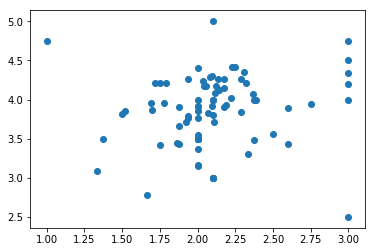

In [25]:
plt.scatter(mi_yelp.Price,mi_yelp.Rating)

In [48]:
mi_FS['Cluster Labels'].iloc[mi_FS[mi_FS['Borough']=='BARONA'].index[0]] # how to extract cluster label from borough name

3

In [61]:
mi_comp_cl = mi_yelp
mi_comp_cl=mi_comp_cl.rename(columns={"Cluster Labels": "Clustering_yelp"})
mi_comp_cl=mi_comp_cl.drop(labels = ["Neighborhood Latitude","Neighborhood Longitude"], axis =1)
#mi_comp_cl["Clustering_FS"]=np.nan

In [63]:
mi_FS_extract = mi_FS[["Borough","Cluster Labels"]]
mi_FS_extract=mi_FS_extract.rename(columns={"Cluster Labels": "Clustering_FS"})

In [54]:
mi_comp_cl["Clustering_FS"] = [mi_FS['Cluster Labels'].iloc[mi_FS[mi_FS['Borough']==vv].index[0]] for vv in mi_yelp["Borough"]]

IndexError: single positional indexer is out-of-bounds

In [66]:
mi_comp_cl.head()

,Clustering_yelp,Borough,Price,Rating
0,0,ADRIANO,2.0,3.850000
1,0,AFFORI,1.7,3.866667
2,2,BAGGIO,2.6,3.888889
3,1,BANDE NERE,2.0,3.166667
4,0,BARONA,2.0,3.500000


In [64]:
mi_FS_extract.head()
#mi_yelp

,Borough,Clustering_FS
0,DUOMO,1
1,BRERA,1
2,GUASTALLA,1
3,Giardini Pta Venezia,1
4,VIGENTINA,3


In [67]:
mi_comp_df=pd.merge(mi_comp_cl,mi_FS_extract,on ="Borough")

I am going to use a confuxion matrix to verify correspondece between clustering methods, and what we'd like to see is a concentrated rather than evenly spread distribution. In fairness we already know that there is a certain overlapping between the two clustering classifications, as for instance we know that central locations are clustered together.

In [70]:
confusion_matrix(mi_comp_df.Clustering_yelp,mi_comp_df.Clustering_FS)

array([[ 2, 15,  0, 14],
       [ 0,  4,  2,  6],
       [ 0,  4,  1,  2],
       [ 0, 24,  0,  7]])

In [84]:
mi_comp_df.Clustering_yelp.unique()
def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

selection_sort(mi_comp_df.Clustering_yelp.unique())

array([0, 1, 2, 3], dtype=int64)

Confusion matrix, without normalization
[[ 2 15  0 14]
 [ 0  4  2  6]
 [ 0  4  1  2]
 [ 0 24  0  7]]


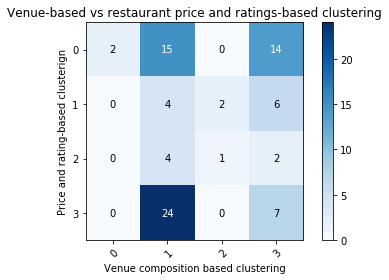

In [85]:
classes = selection_sort(mi_comp_df.Clustering_yelp.unique())
#classes=['0','1','2','3']
plot_confusion_matrix(mi_comp_df.Clustering_yelp, mi_comp_df.Clustering_FS, classes,
                          normalize=False,
                          title="Venue-based vs restaurant price and ratings-based clustering")

In [77]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Price and rating-based clusterign',
           xlabel='Venue composition based clustering')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Final remarks

Venue-composition based clustering (through Foursquare API) was much more polarised s it's no surprise that there is a concentration of clusters for two of its values. Clusters 1 corresponds to the central locations, cluster 3 to the roughly circular distribution of neighbourhoods in working class areas out of the inner ring road. It is good to see how both clustering methods identify these two clusters, and how they overlap at their edges, as shown by the splitting of cluster 0 of price and rating based clustering.